In [3]:
%matplotlib inline
import re
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, calinski_harabaz_score
from pandas import DataFrame

In [4]:
"""
Exercise_1_a
In K-means E-step we do hard assignment that each data point should be assigned  to exactly one particular cluster, 
while GMM does soft assignment that each data point could have been created by several mixture components with different probabilities. 


Exercise_1_b
THE DIFFERENCE:
1. IN GMM, M-STEP earns both means μk and covariances Σk. Points in each cluster are sampled for a Gaussian. 
2. GMM takes variance into consideration when it calculates the measurement. 
K-means only calculates conventional Euclidean distance. 
In other words, K-means calculate distance, while GM calculates “weighted” distance.
"""

'\nExercise_1_a\nIn K-means E-step we do hard assignment that each data point should be assigned  to exactly one particular cluster, \nwhile GMM does soft assignment that each data point could have been created by several mixture components with different probabilities. \n\n\nExercise_1_b\nTHE DIFFERENCE:\n1. IN GMM, M-STEP earns both means μk and covariances Σk. Points in each cluster are sampled for a Gaussian. \n2. GMM takes variance into consideration when it calculates the measurement. \nK-means only calculates conventional Euclidean distance. \nIn other words, K-means calculate distance, while GM calculates “weighted” distance.\n'

In [5]:
# (c)
dataset1 = np.loadtxt("dataset/DS5230_HW4/dataset1.txt",
                    dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)},
                    delimiter="\t")
dataset2 = np.loadtxt("dataset/DS5230_HW4/dataset1.txt",
                   dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)}, 
                   delimiter="\t")
dataset3 = np.loadtxt("dataset/DS5230_HW4/dataset1.txt",
                   dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)}, 
                   delimiter="\t")

=================== data 1 ======================


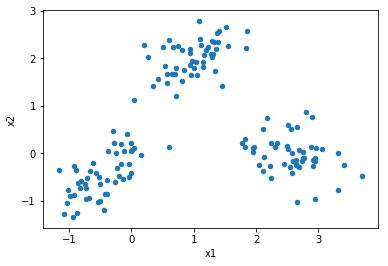

===================== data 2 ===================


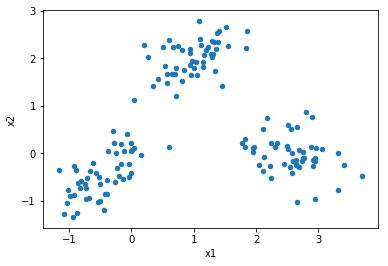

================= data 3 ==================


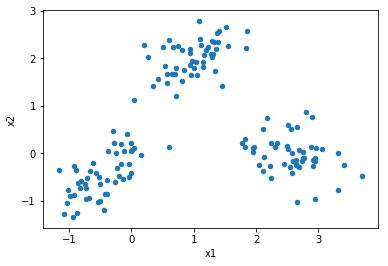

In [6]:
def create_io_matrix(d): 
    """
    formats the input data in a matrix format (n × d) where d is the number of dimentions and n is the number of data points 
    formats the label data in a matrix format (n × 1) where n is the number of data points 
    """
    matrix_input = [[x1, x2] for x1, x2, l in d]
    matrix_labels = [l for x1, x2, l in d]
    
    return (np.array(matrix_input), np.array(matrix_labels))

dataset1_matrix, data1_labels = create_io_matrix(dataset1)
dataset2_matrix, data2_labels = create_io_matrix(dataset2)
dataset3_matrix, data3_labels = create_io_matrix(dataset3)
############# initial data visualization 

df_1 = DataFrame(dataset1_matrix, columns = ['x1', 'x2'])
df_1.plot(kind='scatter', x = 'x1', y = 'x2')

print("=================== data 1 ======================")
plt.show()

df_2 = DataFrame(dataset2_matrix, columns = ['x1', 'x2'])
df_2.plot(kind='scatter', x = 'x1', y = 'x2')

print("===================== data 2 ===================")
plt.show()

df_3 = DataFrame(dataset3_matrix, columns = ['x1', 'x2'])
df_3.plot(kind='scatter', x = 'x1', y = 'x2')

print("================= data 3 ==================")
plt.show()

data1 = np.asarray(dataset1_matrix)
data2 = np.asarray(dataset2_matrix)
data3 = np.asarray(dataset3_matrix)
labels1 = np.asarray(data1_labels)
labels2 = np.asarray(data2_labels)
labels3 = np.asarray(data3_labels)

In [7]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


def plot_clusters(Y, mus, covs, labels, K):
    cmap = plt.cm.get_cmap('hsv', K)
    fig, ax = plt.subplots(figsize=(4, 4))
    colors = ['red', 'blue', 'green']
    for j in range(np.unique(labels).shape[0]):
        Y_j = Y[(labels == (j+1))]
        ax.scatter(Y_j[:, 0], Y_j[:, 1], color=colors[j])
    for i in range(K):
        plot_cov_ellipse(cov=covs[i],
                         pos=mus[i],
                         nstd=2,
                         ax=ax,
                         color=cmap(i),
                         alpha=0.1)

    plt.show()

In [8]:
# Implement the GMM algorithm
from scipy.stats import multivariate_normal

def logsumExp(X):
    return np.max(X) + np.log(np.sum(np.exp(X - np.max(X))))

def logGamma(data, weights, mu, covs):
    num_data = len(data)
    num_clusters = len(mu)
    loggamma = np.zeros((num_data, num_clusters))
    for i in range(num_data):
        for j in range(num_clusters):
            loggamma[i, j] = weights[j]*multivariate_normal.pdf(data[i], mean=mu[j], cov=covs[j])
    
    row_sums = loggamma.sum(axis=1)[:, np.newaxis]
    loggamma = loggamma / row_sums
    return loggamma


def compute_LL(data, weights, mu, covs):
    num_clusters = len(mu)
    num_dim = len(data[0])
    LL = 0
    
    for d in data:
        P = np.zeros(num_clusters)
        for k in range(num_clusters):
            delta = np.array(d) - mu[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            P[k] += np.log(weights[k])
            P[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)

        LL += logsumExp(P)
    return LL
        

def compute_weights(softNum):
    num_clusters = len(softNum)
    weights = [0.] * num_clusters
    for k in range(num_clusters):
        weights[k] = softNum[k] / np.sum(softNum)
    
    return weights


def compute_softAssignment(loggamma):
    softNum = np.sum(loggamma, axis=0)
    return softNum

In [9]:
def compute_covs(data, loggamma, softNum, mu):
    num_clusters = len(softNum)
    num_dim = len(data[0])
    num_data = len(data)
    covs = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = np.zeros((num_dim, num_dim))
        for m in range(num_data):
            weighted_sum += loggamma[m][k]*np.outer(data[m] - mu[k], data[m] - mu[k])
        covs[k] = weighted_sum / softNum[k]
    return covs


def compute_mu(data, loggamma, softNum):
    num_clusters = len(softNum)
    num_data = len(data)
    mu = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = 0.
        for m in range(num_data):
            weighted_sum += data[m] * loggamma[m][k]
        mu[k] = weighted_sum / softNum[k]
    return mu

In [10]:
def GMM(data, init_mu, init_covs, init_weights, maxIter=800, threshold=1e-4):
    mu = init_mu[:]
    covs = init_covs[:]
    weights = init_weights[:]
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(mu)
    
    loggamma = np.zeros((num_data, num_clusters))
    LL = compute_LL(data, weights, mu, covs)
    LL2 = [LL]
    
    for time in range(maxIter):
        
        # Implement E-step
        loggamma = logGamma(data, weights, mu, covs)

        # Implement M-step
        softNum = compute_softAssignment(loggamma)
        weights = compute_weights(softNum)
        mu = compute_mu(data, loggamma, softNum)
        covs = compute_covs(data, loggamma, softNum, mu)

        newLL = compute_LL(data, weights, mu, covs)
        LL2.append(newLL)
        
        if (newLL - LL) < threshold and newLL > -np.inf:
            break
        LL = newLL
    
    result = {'weight': weights, 'mean': mu, 'covariances': covs, 'loglikelihood': LL2, 'LogGamma': loggamma}
    return result

In [11]:
from scipy.stats import multivariate_normal as mvn
def initialization(data, K): 
    """
    gets the initial values of the means and variances 
    means : K × D, where each row is the mean for cluster k
    covs : K × D, where the each row the diagonal elements of covariance for cluster k
    """
    N, D = np.shape(data)
    
    mu_0 = np.mean(data,0)
    cov = np.cov(data.T)
    init_mus = mvn.rvs(size=K, mean=mu_0, cov=cov)
    init_covs = np.tile(cov,(K,1,1))
    return init_mus, init_covs

================= data 1 ==================


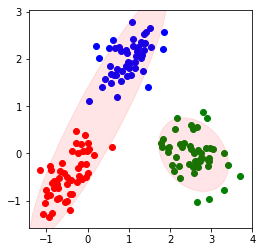

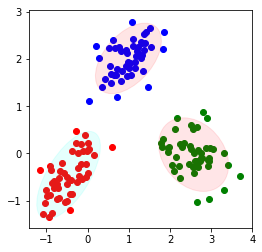

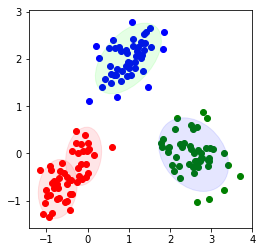

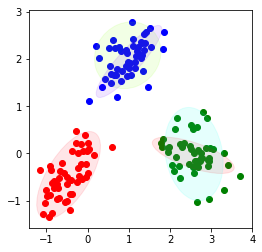

In [12]:
# Now it's time to run GMM for each of the datasets with hyperparameters K = 2,3,4,5

print("================= data 1 ==================")
data1_GMM_results = []
for K in range(2, 6):
    init_mus, init_covs = initialization(dataset1_matrix, K)
    init_weights = [1/K] * K
    
    GMMresult = GMM(dataset1_matrix, init_mus, init_covs, init_weights)
    mus_best, covs_best, log_gammas_best, LLs_best = (GMMresult["mean"], GMMresult["covariances"], GMMresult["LogGamma"],
                                                     GMMresult["loglikelihood"])
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data1, mus_best, covs_best, labels1, K)
    data1_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))

================= data 2 ==================


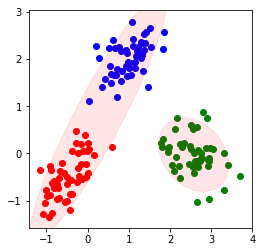

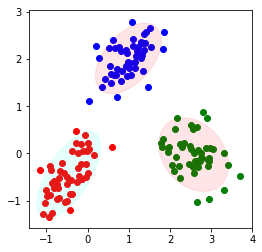

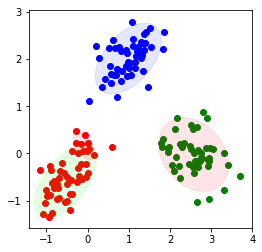

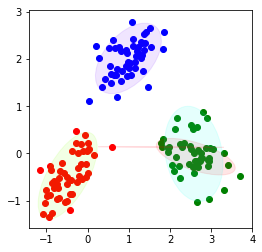

In [13]:
print("================= data 2 ==================")
data2_GMM_results = []
for K in range(2, 6):
    init_mus, init_covs = initialization(dataset2_matrix, K)
    init_weights = [1/K] * K
    
    GMMresult = GMM(dataset2_matrix, init_mus, init_covs, init_weights)
    mus_best, covs_best, log_gammas_best, LLs_best = (GMMresult["mean"], GMMresult["covariances"], GMMresult["LogGamma"],
                                                     GMMresult["loglikelihood"])
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data2, mus_best, covs_best, labels2, K)
    data2_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))

================= data 3 ==================


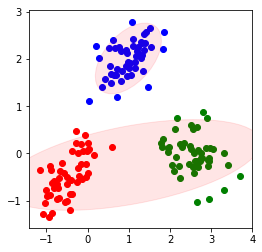

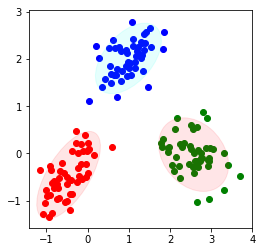

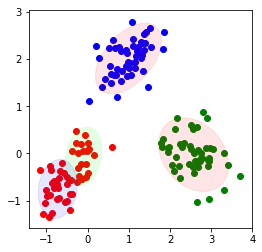

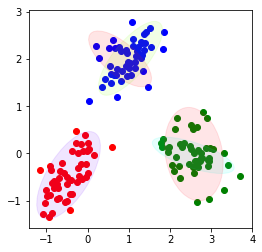

In [14]:
print("================= data 3 ==================")
data3_GMM_results = []
for K in range(2, 6):
    init_mus, init_covs = initialization(dataset3_matrix, K)
    init_weights = [1/K] * K
    
    GMMresult = GMM(dataset3_matrix, init_mus, init_covs, init_weights)
    mus_best, covs_best, log_gammas_best, LLs_best = (GMMresult["mean"], GMMresult["covariances"], GMMresult["LogGamma"],
                                                     GMMresult["loglikelihood"])
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data3, mus_best, covs_best, labels3, K)
    data3_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))

In [15]:
# Get the Evaluation of GMM
def get_clustering_scores_GMM(data_matrix, true_labels, GMM_results): 
    means, variances, predicted_labels, log_likelihood = GMM_results
    NMI = normalized_mutual_info_score(true_labels, predicted_labels)
    SC = 0 
    CH = 0
    try: 
        SC = silhouette_score(data_matrix, predicted_labels)
        CH = calinski_harabaz_score(data_matrix, predicted_labels)
    except ValueError: 
        print("number of clusters = 1")
        
    print("\t NMI: ", NMI)
    print("\t SC: ", SC) 
    print("\t CH: ", CH)
    print("\t Log Likelihood: ", log_likelihood)
    print("------------------------------------------")
    
    return (NMI, SC, CH, log_likelihood)

In [16]:
print("========================= Scores for data 1 =========================")

scores_clustering_data1_GMM = [get_clustering_scores_GMM(data1, data1_labels, data1_GMM_results[i]) 
                           for i in range(4)]

print("========================= Scores for data 2 =========================")

scores_clustering_data2_GMM = [get_clustering_scores_GMM(data2, data2_labels, data2_GMM_results[i]) 
                           for i in range(4)]

print("========================= Scores for data 3 =========================")

scores_clustering_data3_GMM = [get_clustering_scores_GMM(data3, data3_labels, data3_GMM_results[i]) 
                           for i in range(4)]

========================= Scores for data 1 =========================
	 NMI:  0.7611702597222872
	 SC:  0.4901674091014616
	 CH:  115.34691469452436
	 Log Likelihood:  -342.2675564313615
------------------------------------------
	 NMI:  1.0
	 SC:  0.7222054254371456
	 CH:  599.5385825621063
	 Log Likelihood:  -295.9595461767251
------------------------------------------
	 NMI:  0.9104427207123413
	 SC:  0.6305644523416275
	 CH:  524.0878965216092
	 Log Likelihood:  -291.7385786562088
------------------------------------------
	 NMI:  0.8426532556376279
	 SC:  0.279649481585991
	 CH:  298.571401336582
	 Log Likelihood:  -287.91604188482637
------------------------------------------
========================= Scores for data 2 =========================
	 NMI:  0.7611702597222872
	 SC:  0.4901674091014616
	 CH:  115.34691469452436
	 Log Likelihood:  -342.2675564330277
------------------------------------------
	 NMI:  1.0
	 SC:  0.7222054254371456
	 CH:  599.5385825621063
	 Log Likelihood

GMM: data 1 NMI scores for clusters with k in the x axis and the score in the y


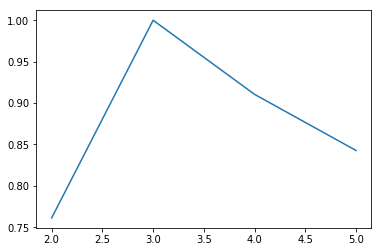

GMM: data 1 CH scores for clusters with k in the x axis and the score in the y


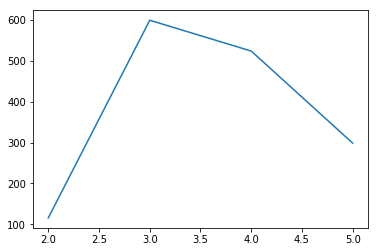

GMM: data 1 SC scores for clusters with k in the x axis and the score in the y


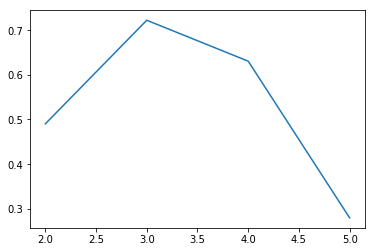

GMM: data 1 log likelihood scores for clusters with k in the x axis and the score in the y


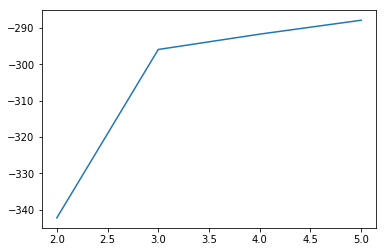

data 2 NMI scores for clusters with k in the x axis and the score in the y


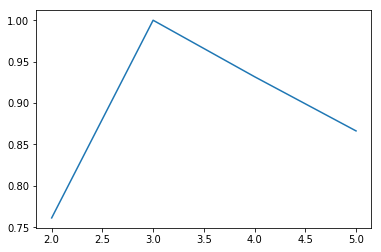

data 2 CH scores for clusters with k in the x axis and the score in the y


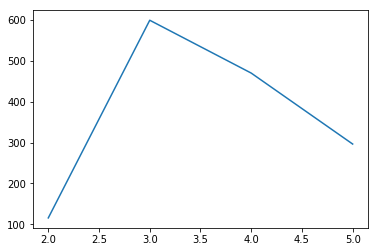

data 2 SC scores for clusters with k in the x axis and the score in the y


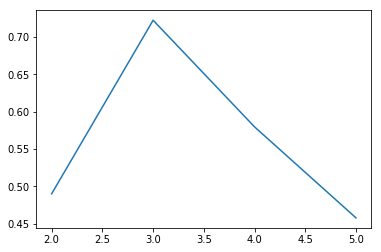

data 2 log likelihood scores for clusters with k in the x axis and the score in the y


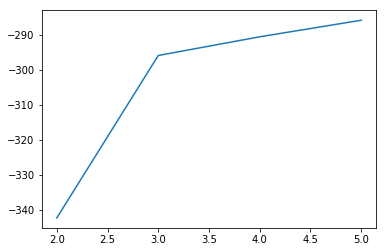

data 3 NMI scores for clusters with k in the x axis and the score in the y


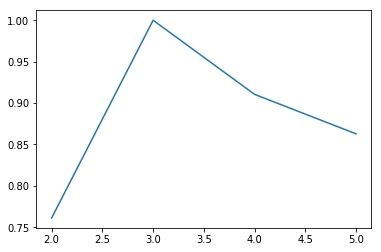

data 3 CH scores for clusters with k in the x axis and the score in the y


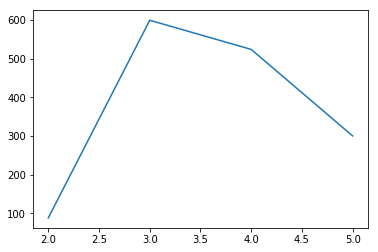

data 3 SC scores for clusters with k in the x axis and the score in the y


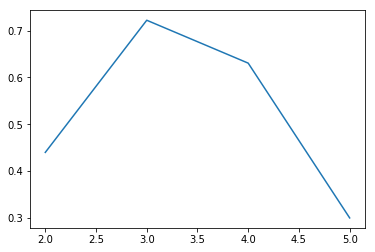

data 3 log likelihood scores for clusters with k in the x axis and the score in the y


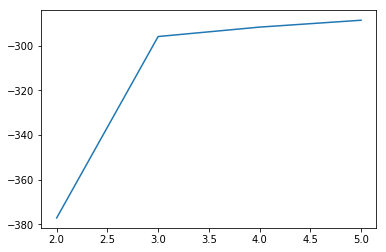

In [17]:
# For each dataset, plot the log likelihood, the CH index, the SC, and the NMI as a function of K = 2, 3, 4, 5

NMI_data1_GMM = []
SC_data1_GMM = []
CH_data1_GMM = []
ll_data1_GMM = []

for NMI, SC, CH, ll in scores_clustering_data1_GMM: 
    NMI_data1_GMM.append(NMI)
    SC_data1_GMM.append(SC)
    CH_data1_GMM.append(CH)
    ll_data1_GMM.append(ll)

NMI_data2_GMM = []
SC_data2_GMM = []
CH_data2_GMM = []
ll_data2_GMM = []

for NMI, SC, CH, ll in scores_clustering_data2_GMM: 
    NMI_data2_GMM.append(NMI)
    SC_data2_GMM.append(SC)
    CH_data2_GMM.append(CH)
    ll_data2_GMM.append(ll)

NMI_data3_GMM = []
SC_data3_GMM = []
CH_data3_GMM = []
ll_data3_GMM = []

for NMI, SC, CH, ll in scores_clustering_data3_GMM: 
    NMI_data3_GMM.append(NMI)
    SC_data3_GMM.append(SC)
    CH_data3_GMM.append(CH)
    ll_data3_GMM.append(ll)


print("GMM: data 1 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data1_GMM)
plt.show()
    
print("GMM: data 1 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data1_GMM)
plt.show()

print("GMM: data 1 SC scores for clusters with k in the x axis and the score in the y")  
plt.plot([2, 3, 4, 5], SC_data1_GMM)
plt.show()

print("GMM: data 1 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data1_GMM)
plt.show()


print("data 2 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data2_GMM)
plt.show()
    
print("data 2 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data2_GMM)
plt.show()


print("data 2 SC scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], SC_data2_GMM)
plt.show()


print("data 2 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data2_GMM)    
plt.show()
print("data 3 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data3_GMM) 
plt.show()
    
print("data 3 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data3_GMM)
plt.show()

print("data 3 SC scores for clusters with k in the x axis and the score in the y")  
plt.plot([2, 3, 4, 5], SC_data3_GMM)
plt.show()

print("data 3 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data3_GMM)
plt.show()

    

In [ ]:
# Exercise 2 (1)
# Do the data cleaning on raw dataset
rtitle = re.compile(r'^#\*\s*(.+)')
stemmer = SnowballStemmer('english')
titles = []
stopwords = []
parsed_titles = []

with open('dataset/DS5230_HW4/stopwords_english.txt') as fsw:
    for word in fsw.readlines():
        word = word.strip('\n')
        stopwords.append(word)
fsw.close()

with open('dataset/DS5230_HW4/publications.txt') as fin:
    for line in fin.readlines():
        line = line.strip('\n')
        mtitle = rtitle.match(line)
        ## if it is a title string
        if mtitle:
            title = mtitle.group(1).lower()
            titles.append(title[:-1])
fin.close()

fout = open('dataset/DS5230_HW4/stopwords_english.txt', 'w+')
for i, words in enumerate(titles):
    words = words.split(" ")
    words = [re.match('[a-zA-Z0-9]+', stemmer.stem(word)).group() for word in words if re.match('[a-zA-Z0-9]+', stemmer.stem(word)) is not None]
    words = ['NUM' if re.match('[0-9]+', word) is not None else word for word in words]
    words = list(filter(None, ["" if word in stopwords else word for word in words]))
    words = ' '.join(words)
    fout.write(words + '\n')
    parsed_titles.append(words)
    if i % 100000 == 0 :
        print(i)
fout.close()

0


In [ ]:
# (2) 
# Apply LDA to the titles_prep.txt
titles_prep = []
data = open('dataset/DS5230_HW4/preprocessed.txt')
Lines = data.readlines()
for line in Lines:
    line = line.rstrip('\n')
    titles_prep.append(line)
    
vectorizer = CountVectorizer(min_df = 800)
wordCounts = vectorizer.fit_transform(titles_prep)
# Set topic number = 10
lda_1 = LatentDirichletAllocation(n_components = 10, learning_method = 'online')
lda_result1 = lda_1.fit_transform(wordCounts)

# Set topic number = 20
lda_2 = LatentDirichletAllocation(n_components = 20, learning_method = 'online')
lda_result2 = lda_2.fit_transform(wordCounts)

# Set topic number = 50
lda_3 = LatentDirichletAllocation(n_components = 50, learning_method = 'online')
lda_result3 = lda_3.fit_transform(wordCounts)

In [ ]:
# A function to find the top n words for each component (topic) in a descending order, using LDA method 
# Set num_topwords = 10 for the problem
LDAnames = vectorizer.get_feature_names()
def topwords_LDA(feature_names, lda, num_topwords):
    for topicIndex, topic in enumerate(lda.components_):
        print ("Topic : %d" % (topicIndex))
        print (", ".join([feature_names[i]
                        for i in topic.argsort()[:-num_topwords - 1:-1]]))
# topic number = 10
topwords_LDA(LDAnames, lda_1, 10)

# topic number = 20
topwords_LDA(LDAnames, lda_2, 10)

#  topic number = 50
topwords_LDA(LDAnames, lda_3, 10)

In [ ]:
"""
From the above results, we can find that for differnet number of components, the top 10 words for first several topics
are quite different, sharing few common words.And as the number of components increases, more new words, instead of already shown words, occured as top 10 words. 
"""

In [ ]:
# (3)
pca_1 = TruncatedSVD(n_components=10)
reduced_X1 = pca_1.fit_transform(wordCounts)

pca_2 = TruncatedSVD(n_components=20)
reduced_X2 = pca_2.fit_transform(wordCounts)

pca_3 = TruncatedSVD(n_components=50)
reduced_X3 = pca_3.fit_transform(wordCounts)

In [ ]:
def topwords_PCA(cv, pca, num_topwords):
    #print the top words based on the eigenvectors 
    Topwords = []
    vocab = {v: k for k, v in cv.vocabulary_.items()}
    eigenvectors = pca.components_
    for k,ev in enumerate(eigenvectors):
        ev_indices = np.argsort(- np.abs(ev))[:num_topwords]
        ev_topwords =', '.join([vocab[ind] for ind in ev_indices])
        Topwords.append(ev_topwords)
        print("COMPOENT : %d, TOPWORDS : %s" % (k, ev_topwords))
        
# n_components = 10
topwords_PCA(vectorizer, pca_1, 10)

# n_components = 20
topwords_PCA(vectorizer, pca_2, 10)

# n_components = 50
topwords_PCA(vectorizer, pca_3, 10)



In [ ]:
"""
FROM THE ABOVE RESULTS, WE CAN FIND THAT DIFFERNET NUMBER OF COMPONENTS, 
THE TOP 10 WORDS FOR FIRST TOPICS ARE SAME, HAVING LOTS OF COMMON WORDS.
"""

# QUESTION4
"""ACCORDING TO THE RESULTS, I DON'T THINK THE LDA OUTPERFORMS PCA IN THE TOPIC MODELING JOB. 
THIS IS BECASE IN THE ASPECT OF ROBUSTNESS, LDA RESULT IS WEAKER THAN THAT OF PCA REUSLT. 
BUT AS FOT THTSEMANTIC COHERENCE, LDA COULD PERFORM BETTER THAN PCA.
"""
